In [83]:
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import random
from sklearn.manifold import TSNE

In [84]:

class KMEANS(nn.Module):
    def __init__(self, inputMatrix, n_clusters=10, device = torch.device("cuda:0")):
        super(KMEANS, self).__init__()
        self.matrix = inputMatrix
        self.n_clusters = n_clusters
        self.device = device
        self.alpha = 10
        # torch.manual_seed(3)
        init_row = torch.randint(0, inputMatrix.shape[0], (self.n_clusters,))
        init_points = inputMatrix[init_row]
        self.centers = nn.Parameter(init_points)

    def caldis(self, x, op):
        centers = self.centers.squeeze(0)
        ## 1
#         centers = centers.expand(x.shape[0], self.n_clusters, centers.shape[1]) # [1000,10,784]
#         x = x.expand(self.n_clusters,x.shape[0],x.shape[1])
#         x = x.transpose(1, 0)
        ## 2
        centers = centers.reshape(1,centers.shape[0],centers.shape[1])
        centers = centers.repeat(x.shape[0], 1, 1)
        x = x.reshape(x.shape[0], 1 , x.shape[1])
        x = x.repeat(1, self.n_clusters, 1)
        
        if op == 'l2':
            distance = torch.sum((x - centers) ** 2, axis=-1)
        elif op == 'l1':
            distance = torch.sum(torch.abs(x - centers), axis=-1)
        return distance

#     def calwei(self, distance):
#         distance = torch.log(distance + 1)
#         we = torch.exp(-self.alpha * distance)
#         sum = torch.sum(we, axis=1)
#         sum = sum.expand(we.shape[1], we.shape[0]).transpose(0, 1)
#         weight = we / sum
#         return weight

    def calwei2(self, distance):
        index = torch.sort(distance)
        y_p = index[1][:, 0].unsqueeze(0).type(torch.LongTensor)
        weight = torch.FloatTensor(1, len(distance), self.n_clusters)
        weight.zero_()
        weight.scatter_(2, torch.unsqueeze(y_p, 2), 1)
        weight = weight.squeeze(0)
        return weight


    def calloss(self, distance, weight):
        loss = torch.sum(weight * distance)
        return loss
    
    def loss2(self, x, y):
        true = self.centers[y]
        loss = criterion(x, true)
        return loss
    
    def quchong(self,bin, label_max, ind_already):
        bin[label_max] = 0
        max = torch.max(bin)
        if max == 0:
            return []
        label_max = torch.where(bin == max)[0][0]
        if label_max in ind_already:
            self.quchong(bin, label_max, ind_already)
        return label_max

    def predict_acc(self, distance, y, min_index):
        index = torch.sort(distance)
        y_p = index[1][:,0]
        y_p = min_index

        ind_already = []
        correct = 0
        for i in range(10):
            id = torch.where(y_p == i)
            temp = y[id]
            bin = torch.bincount(temp)
            try:
                max = torch.max(bin)
            except:
                continue
            label_max = torch.where(bin == max)[0][0]
            if label_max in ind_already:
                label_max = self.quchong(bin, label_max, ind_already)
            if label_max != []:
                correct += bin[label_max]
                ind_already.append(label_max)
        acc = correct/(len(distance)*1.0)
        return acc
        

    def forward(self, x, y, op = 'l2'):
        distance = self.caldis(x, op)
#         weight = self.calwei(distance)
        # ynew = self.predict(distance)
#         loss = self.calloss(distance, weight)
        min_d, min_index = distance.min(-1)
        loss = min_d.sum()
        #acc = self.predict_acc(distance, y, min_index)
        return loss, min_index

In [41]:

def div(dataset, labels, batchsize):
    list_data =[]
    for i in range(len(dataset)//batchsize):
        data = (dataset[i*batchsize:(i+1)*batchsize])
        y = (labels[i*batchsize:(i+1)*batchsize])
        tupple = (data,y)
        list_data.append(tupple)
    return list_data
def getnext(examples):
    batch_idx, (example_data, example_targets) = next(examples)
    X = example_data.view(-1, 784)
    Y = example_targets
    return X, Y

def plot_embedding(data, label, title):
    x_min, x_max = np.min(data, 0), np.max(data, 0)
    data = (data - x_min) / (x_max - x_min)

    fig = plt.figure()
    ax = plt.subplot(111)
    for i in range(label.shape[0]):
        plt.text(data[i, 0], data[i, 1], str(label[i]),
                 color=plt.cm.Set1(label[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    return fig, x_max, x_min

def kmeans(X, Y, batch_size = 10000, num_epochs = 70, ae =True):
    dataset = div(X, Y, batch_size)
    k = KMEANS(n_clusters=10, inputMatrix=X, ae = ae)
    optimizer = torch.optim.Adam(k.parameters(), lr=0.01)
    acc = []
    loss = []
    for epoch in range(num_epochs):
        for i, data in enumerate(dataset, 0):
            # i = 0
            (inputs, labels) = data
            X, Y = Variable(inputs), Variable(labels)
            optimizer.zero_grad()  # Intialize the hidden weight to all zeros
            loss_this, acc_this = k.forward(X, Y, op='l2')
            loss.append(loss_this)
            acc.append(acc_this)
            loss[-1].backward(retain_graph=True)  # Backward pass: compute the weight
            optimizer.step()  # Optimizer: update the weights of hidden nodes

            if i + 1:  # Logging
                print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Acc: %.4f, '
                      % (epoch + 1, num_epochs, i + 1, datasize // batch_size, loss[-1], acc[-1]))
            # i = i+1

    for i in range(9):
        print(sum((k.centers[i] - k.centers[i + 1]) ** 2))

    ax = range(num_epochs * (datasize // batch_size))
    plt.title('acc')
    plt.xlabel('epochs')
    plt.plot(ax, acc, 'r', linewidth=2)
    plt.show()




In [99]:
torch.rand(1)/100

tensor([0.0025])

In [86]:
batch_size=1000
# train_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('./files/', train=True, download=True,
#                                                                      transform=torchvision.transforms.Compose([
#                                                                          torchvision.transforms.ToTensor(),])), 
#                                            batch_size=batch_size,shuffle=False)
# examples = enumerate(train_loader)
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                             ])),
  batch_size=10000, shuffle=False)
examples = enumerate(train_loader)

X, Y = getnext(examples)

In [87]:

class Autoencoder(nn.Module):
    def __init__(self, n_clusters, batch_size, num1, num2, num3, alpha = 0.0001,numbda = 0):
        super(Autoencoder, self).__init__()
        # self.matrix = inputMatrix
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.numbda = numbda
        self.beta = 1
        self.centers = None
        self.acc = 0
        self.criteron = nn.MSELoss()
        self.we = torch.zeros((batch_size, n_clusters))
        self.mid = None

        self.encoder = nn.Sequential(
            # nn.Conv1d(1, num1, kernel_size=5),
            # nn.ReLU(True),
            # nn.Conv1d(num1, num2, kernel_size=5),
            # nn.ReLU(True)
            ####### linear ####################
            nn.Linear(784, num1),
            nn.ReLU(True),
            nn.Linear(num1, num2),
            nn.ReLU(True),
            nn.Linear(num2, num3),
#            nn.ReLU(True),
#             nn.Linear(num, 10),
#             nn.ReLU(True),
            # nn.Linear(num2, num3),
            # nn.ReLU(True)
            )
        self.decoder = nn.Sequential(
            # nn.ConvTranspose1d(num2, num1, kernel_size=5),
            # nn.ReLU(True),
            # nn.ConvTranspose1d(num1, 1, kernel_size=5),
            # nn.ReLU(True)
            ####### linear ####################
            # nn.Linear(num3, num2),
            # nn.ReLU(True),
            # nn.Linear(10, 2000),
            # nn.ReLU(True),
            nn.Linear(num3, num2),
            nn.ReLU(True),
            nn.Linear(num2, num1),
            nn.ReLU(True),
            nn.Linear(num1, 784),
            nn.ReLU(True),
            )
    
    def callossae(self, input, output):
        # loss = torch.sum((input - output) ** 2)
        loss = self.criteron(input, output)
        return loss

    def callossk(self, distance, weight):
        loss = torch.sum(weight * distance)
        return loss

    def forward(self, x, y, op):
        self.mid = self.encoder(x)
        
#         kmeans = KMeans(n_clusters=10).fit(mid)
        
#         center = torch.from_numpy(kmeans.cluster_centers_)
#         distance = self.caldis(mid, op)
#         min_d, min_index = distance.min(-1)
#         lossk = min_d.sum()
        
        out = self.decoder(self.mid)
        loss_ae = self.callossae(x, out)
        
        loss = loss_ae
        return  loss, self.mid



In [88]:
datasize = 10000                    ###################
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                             ])),
  batch_size=datasize, shuffle=False)
examples = enumerate(train_loader)
X, Y = getnext(examples)

In [127]:
num_epochs = 750
batch_size = 10000
n1 = 50
n2 = 20
n3 = 5

dataset = div(X, Y, batch_size)
model = Autoencoder(n_clusters= 10, batch_size=batch_size, num1 = n1, num2 = n2, num3 = n3, alpha = 1, numbda = 0).cuda()
# distance = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=0, lr = 0.005)

loss = []
acc = []
for epoch in range(num_epochs):
    for i, data in enumerate(dataset, 0):
        X, Y = data
        # X = X.unsqueeze(0).transpose(0, 1).,m/
        X = Variable(X).cuda()
        Y = Variable(Y).cuda()
        # ===================forward=====================
        loss_this, mid= model(X,Y, op = 'l2')

#             correct_ct = 0
#             for c in torch.unique(min_index):
#                 pred_c_idx = (min_index == c).nonzero().squeeze(-1)
#                 ct_of_each_gt_class = torch.bincount(Y[pred_c_idx])
#                 correct_ct += torch.max(ct_of_each_gt_class)
#             acc_this = correct_ct.item()/len(Y)

        loss.append(loss_this)
#             acc.append(acc_this)
        # ===================backward====================
        optimizer.zero_grad()
        loss[-1].backward()
        optimizer.step()
        # ===================log========================
#             print(
#                 'epoch [{}/{}], Step [{}/{}], acc:{:.4f}, loss:{:.4f}, lossae:{:.4f}, lossk:{:.4f}, middle:{}'.format(epoch + 1, num_epochs, i + 1, datasize // batch_size,
#                                                                   acc[-1], loss[-1], loss_ae, loss_k, torch.max(mid)))
        if epoch %50 == 0:
            kmeans = KMeans(n_clusters=10).fit(model.mid.detach().cpu())
            acc = calacc(torch.from_numpy(kmeans.labels_), Y)
        print(
            'epoch [{}/{}], Step [{}/{}], loss:{:.4f}, acc:{:.4f}'.format(epoch + 1, num_epochs, i + 1, datasize // batch_size,
                                                              loss[-1], acc))




epoch [1/750], Step [1/1], loss:0.1060, acc:0.2939
epoch [2/750], Step [1/1], loss:0.1030, acc:0.2939
epoch [3/750], Step [1/1], loss:0.0995, acc:0.2939
epoch [4/750], Step [1/1], loss:0.0949, acc:0.2939
epoch [5/750], Step [1/1], loss:0.0907, acc:0.2939
epoch [6/750], Step [1/1], loss:0.0878, acc:0.2939
epoch [7/750], Step [1/1], loss:0.0844, acc:0.2939
epoch [8/750], Step [1/1], loss:0.0825, acc:0.2939
epoch [9/750], Step [1/1], loss:0.0811, acc:0.2939
epoch [10/750], Step [1/1], loss:0.0801, acc:0.2939
epoch [11/750], Step [1/1], loss:0.0797, acc:0.2939
epoch [12/750], Step [1/1], loss:0.0793, acc:0.2939
epoch [13/750], Step [1/1], loss:0.0789, acc:0.2939
epoch [14/750], Step [1/1], loss:0.0787, acc:0.2939
epoch [15/750], Step [1/1], loss:0.0785, acc:0.2939
epoch [16/750], Step [1/1], loss:0.0782, acc:0.2939
epoch [17/750], Step [1/1], loss:0.0780, acc:0.2939
epoch [18/750], Step [1/1], loss:0.0778, acc:0.2939
epoch [19/750], Step [1/1], loss:0.0775, acc:0.2939
epoch [20/750], Step 

epoch [164/750], Step [1/1], loss:0.0425, acc:0.4724
epoch [165/750], Step [1/1], loss:0.0424, acc:0.4724
epoch [166/750], Step [1/1], loss:0.0423, acc:0.4724
epoch [167/750], Step [1/1], loss:0.0423, acc:0.4724
epoch [168/750], Step [1/1], loss:0.0423, acc:0.4724
epoch [169/750], Step [1/1], loss:0.0422, acc:0.4724
epoch [170/750], Step [1/1], loss:0.0422, acc:0.4724
epoch [171/750], Step [1/1], loss:0.0421, acc:0.4724
epoch [172/750], Step [1/1], loss:0.0421, acc:0.4724
epoch [173/750], Step [1/1], loss:0.0421, acc:0.4724
epoch [174/750], Step [1/1], loss:0.0420, acc:0.4724
epoch [175/750], Step [1/1], loss:0.0420, acc:0.4724
epoch [176/750], Step [1/1], loss:0.0419, acc:0.4724
epoch [177/750], Step [1/1], loss:0.0419, acc:0.4724
epoch [178/750], Step [1/1], loss:0.0420, acc:0.4724
epoch [179/750], Step [1/1], loss:0.0421, acc:0.4724
epoch [180/750], Step [1/1], loss:0.0423, acc:0.4724
epoch [181/750], Step [1/1], loss:0.0423, acc:0.4724
epoch [182/750], Step [1/1], loss:0.0420, acc:

epoch [326/750], Step [1/1], loss:0.0377, acc:0.4838
epoch [327/750], Step [1/1], loss:0.0377, acc:0.4838
epoch [328/750], Step [1/1], loss:0.0376, acc:0.4838
epoch [329/750], Step [1/1], loss:0.0377, acc:0.4838
epoch [330/750], Step [1/1], loss:0.0377, acc:0.4838
epoch [331/750], Step [1/1], loss:0.0377, acc:0.4838
epoch [332/750], Step [1/1], loss:0.0376, acc:0.4838
epoch [333/750], Step [1/1], loss:0.0376, acc:0.4838
epoch [334/750], Step [1/1], loss:0.0376, acc:0.4838
epoch [335/750], Step [1/1], loss:0.0376, acc:0.4838
epoch [336/750], Step [1/1], loss:0.0376, acc:0.4838
epoch [337/750], Step [1/1], loss:0.0376, acc:0.4838
epoch [338/750], Step [1/1], loss:0.0376, acc:0.4838
epoch [339/750], Step [1/1], loss:0.0376, acc:0.4838
epoch [340/750], Step [1/1], loss:0.0376, acc:0.4838
epoch [341/750], Step [1/1], loss:0.0377, acc:0.4838
epoch [342/750], Step [1/1], loss:0.0378, acc:0.4838
epoch [343/750], Step [1/1], loss:0.0380, acc:0.4838
epoch [344/750], Step [1/1], loss:0.0381, acc:

epoch [488/750], Step [1/1], loss:0.0359, acc:0.5221
epoch [489/750], Step [1/1], loss:0.0359, acc:0.5221
epoch [490/750], Step [1/1], loss:0.0358, acc:0.5221
epoch [491/750], Step [1/1], loss:0.0358, acc:0.5221
epoch [492/750], Step [1/1], loss:0.0359, acc:0.5221
epoch [493/750], Step [1/1], loss:0.0359, acc:0.5221
epoch [494/750], Step [1/1], loss:0.0359, acc:0.5221
epoch [495/750], Step [1/1], loss:0.0359, acc:0.5221
epoch [496/750], Step [1/1], loss:0.0358, acc:0.5221
epoch [497/750], Step [1/1], loss:0.0358, acc:0.5221
epoch [498/750], Step [1/1], loss:0.0358, acc:0.5221
epoch [499/750], Step [1/1], loss:0.0358, acc:0.5221
epoch [500/750], Step [1/1], loss:0.0358, acc:0.5221
epoch [501/750], Step [1/1], loss:0.0358, acc:0.5218
epoch [502/750], Step [1/1], loss:0.0358, acc:0.5218
epoch [503/750], Step [1/1], loss:0.0358, acc:0.5218
epoch [504/750], Step [1/1], loss:0.0358, acc:0.5218
epoch [505/750], Step [1/1], loss:0.0358, acc:0.5218
epoch [506/750], Step [1/1], loss:0.0359, acc:

epoch [651/750], Step [1/1], loss:0.0351, acc:0.5231
epoch [652/750], Step [1/1], loss:0.0351, acc:0.5231
epoch [653/750], Step [1/1], loss:0.0351, acc:0.5231
epoch [654/750], Step [1/1], loss:0.0351, acc:0.5231
epoch [655/750], Step [1/1], loss:0.0351, acc:0.5231
epoch [656/750], Step [1/1], loss:0.0351, acc:0.5231
epoch [657/750], Step [1/1], loss:0.0352, acc:0.5231
epoch [658/750], Step [1/1], loss:0.0352, acc:0.5231
epoch [659/750], Step [1/1], loss:0.0352, acc:0.5231
epoch [660/750], Step [1/1], loss:0.0351, acc:0.5231
epoch [661/750], Step [1/1], loss:0.0351, acc:0.5231
epoch [662/750], Step [1/1], loss:0.0350, acc:0.5231
epoch [663/750], Step [1/1], loss:0.0350, acc:0.5231
epoch [664/750], Step [1/1], loss:0.0350, acc:0.5231
epoch [665/750], Step [1/1], loss:0.0350, acc:0.5231
epoch [666/750], Step [1/1], loss:0.0351, acc:0.5231
epoch [667/750], Step [1/1], loss:0.0351, acc:0.5231
epoch [668/750], Step [1/1], loss:0.0351, acc:0.5231
epoch [669/750], Step [1/1], loss:0.0351, acc:

In [129]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10).fit(model.mid.detach().cpu())
acc = calacc(torch.from_numpy(kmeans.labels_), Y)
print(acc)

0.5382


In [37]:
b = torch.randint(5,(1,10))
print(b==1)

tensor([[False,  True, False, False, False,  True, False, False, False, False]])


In [38]:
print((b==1).nonzero()[:][:,1])

tensor([1, 5])


In [82]:
11%3


2

In [50]:
def calacc(y_p, Y):
    correct_ct = 0
    for c in torch.unique(y_p):
        pred_c_idx = (y_p == c).nonzero().squeeze(-1)
        ct_of_each_gt_class = torch.bincount(Y[pred_c_idx])
        correct_ct += torch.max(ct_of_each_gt_class)
    acc = correct_ct.item()/len(Y)
    return acc

In [214]:
kmeans = KMEANS(model.mid)

In [175]:
num_epochs = 400
batch_size = 1000
n1 = 64
n2 = 32
n3 = 16

dataset = div(X, Y, batch_size)
model = Autoencoder(n_clusters= 10, batch_size=batch_size, num1 = n1, num2 = n2, num3 = n3, alpha = 10, numbda = 0.001)
# distance = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=0, lr = 0.001)

loss = []
acc = []
for epoch in range(num_epochs):
    for i, data in enumerate(dataset, 0):
        X, Y = data
        # X = X.unsqueeze(0).transpose(0, 1).,m/
        X = Variable(X)
        Y = Variable(Y)
        # ===================forward=====================
        loss_ae, mid = model(X,Y, op = 'l2')
        loss_k, min_index = kmeans(mid,Y)
        loss_this = loss_ae + loss_k
        
        correct_ct = 0
        for c in torch.unique(min_index):
            pred_c_idx = (min_index == c).nonzero().squeeze(-1)
            ct_of_each_gt_class = torch.bincount(Y[pred_c_idx])
            correct_ct += torch.max(ct_of_each_gt_class)
        acc_this = correct_ct.item()/len(Y)

        loss.append(loss_this)
        acc.append(acc_this)
        # ===================backward====================
        optimizer.zero_grad()
        loss[-1].backward()
        optimizer.step()
        # ===================log========================
        print(
                'epoch [{}/{}], Step [{}/{}], acc:{:.4f}, loss:{:.4f}, lossae:{:.4f}, lossk:{:.4f}'.format(epoch + 1, num_epochs, i + 1, datasize // batch_size,
                                                                  acc[-1], loss[-1], loss_ae, loss_k))

#         print(
#             'epoch [{}/{}], Step [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, i + 1, datasize // batch_size,
#                                                               loss[-1]))





epoch [1/400], Step [1/1], acc:0.1170, loss:68811.2734, lossae:0.1047, lossk:68811.1719
epoch [2/400], Step [1/1], acc:0.1170, loss:68350.6875, lossae:0.1042, lossk:68350.5859
epoch [3/400], Step [1/1], acc:0.1170, loss:67767.0938, lossae:0.1037, lossk:67766.9922
epoch [4/400], Step [1/1], acc:0.1170, loss:66921.3984, lossae:0.1033, lossk:66921.2969
epoch [5/400], Step [1/1], acc:0.1170, loss:65815.6953, lossae:0.1028, lossk:65815.5938
epoch [6/400], Step [1/1], acc:0.1170, loss:64531.2305, lossae:0.1023, lossk:64531.1289
epoch [7/400], Step [1/1], acc:0.1170, loss:63119.6992, lossae:0.1018, lossk:63119.5977
epoch [8/400], Step [1/1], acc:0.1170, loss:61609.8008, lossae:0.1013, lossk:61609.6992
epoch [9/400], Step [1/1], acc:0.1170, loss:60021.6523, lossae:0.1007, lossk:60021.5508
epoch [10/400], Step [1/1], acc:0.1170, loss:58368.8789, lossae:0.1001, lossk:58368.7773
epoch [11/400], Step [1/1], acc:0.1170, loss:56665.8672, lossae:0.0993, lossk:56665.7695
epoch [12/400], Step [1/1], ac

epoch [94/400], Step [1/1], acc:0.1170, loss:12661.6641, lossae:0.0772, lossk:12661.5869
epoch [95/400], Step [1/1], acc:0.1170, loss:12645.0918, lossae:0.0772, lossk:12645.0146
epoch [96/400], Step [1/1], acc:0.1170, loss:12629.2021, lossae:0.0771, lossk:12629.1250
epoch [97/400], Step [1/1], acc:0.1170, loss:12614.0615, lossae:0.0771, lossk:12613.9844
epoch [98/400], Step [1/1], acc:0.1170, loss:12599.7109, lossae:0.0771, lossk:12599.6338
epoch [99/400], Step [1/1], acc:0.1170, loss:12586.0283, lossae:0.0770, lossk:12585.9512
epoch [100/400], Step [1/1], acc:0.1170, loss:12572.9229, lossae:0.0770, lossk:12572.8457
epoch [101/400], Step [1/1], acc:0.1170, loss:12560.2998, lossae:0.0770, lossk:12560.2227
epoch [102/400], Step [1/1], acc:0.1170, loss:12548.1035, lossae:0.0770, lossk:12548.0264
epoch [103/400], Step [1/1], acc:0.1170, loss:12536.5049, lossae:0.0770, lossk:12536.4277
epoch [104/400], Step [1/1], acc:0.1170, loss:12525.5225, lossae:0.0769, lossk:12525.4453
epoch [105/400],

epoch [190/400], Step [1/1], acc:0.1170, loss:11909.1572, lossae:0.0742, lossk:11909.0830
epoch [191/400], Step [1/1], acc:0.1170, loss:11902.9746, lossae:0.0741, lossk:11902.9004
epoch [192/400], Step [1/1], acc:0.1170, loss:11896.8291, lossae:0.0740, lossk:11896.7549
epoch [193/400], Step [1/1], acc:0.1170, loss:11890.6836, lossae:0.0740, lossk:11890.6094
epoch [194/400], Step [1/1], acc:0.1170, loss:11884.5684, lossae:0.0739, lossk:11884.4941
epoch [195/400], Step [1/1], acc:0.1170, loss:11878.4580, lossae:0.0739, lossk:11878.3838
epoch [196/400], Step [1/1], acc:0.1170, loss:11872.3691, lossae:0.0738, lossk:11872.2949
epoch [197/400], Step [1/1], acc:0.1170, loss:11866.2939, lossae:0.0738, lossk:11866.2197
epoch [198/400], Step [1/1], acc:0.1170, loss:11860.2275, lossae:0.0738, lossk:11860.1533
epoch [199/400], Step [1/1], acc:0.1170, loss:11854.1631, lossae:0.0737, lossk:11854.0889
epoch [200/400], Step [1/1], acc:0.1170, loss:11848.1084, lossae:0.0737, lossk:11848.0352
epoch [201

epoch [285/400], Step [1/1], acc:0.1170, loss:11386.2686, lossae:0.0735, lossk:11386.1953
epoch [286/400], Step [1/1], acc:0.1170, loss:11381.2451, lossae:0.0735, lossk:11381.1719
epoch [287/400], Step [1/1], acc:0.1170, loss:11376.2930, lossae:0.0735, lossk:11376.2197
epoch [288/400], Step [1/1], acc:0.1170, loss:11371.2822, lossae:0.0735, lossk:11371.2090
epoch [289/400], Step [1/1], acc:0.1170, loss:11366.2998, lossae:0.0735, lossk:11366.2266
epoch [290/400], Step [1/1], acc:0.1170, loss:11361.3496, lossae:0.0735, lossk:11361.2764
epoch [291/400], Step [1/1], acc:0.1170, loss:11356.3740, lossae:0.0735, lossk:11356.3008
epoch [292/400], Step [1/1], acc:0.1170, loss:11351.4082, lossae:0.0735, lossk:11351.3350
epoch [293/400], Step [1/1], acc:0.1170, loss:11346.4551, lossae:0.0735, lossk:11346.3818
epoch [294/400], Step [1/1], acc:0.1170, loss:11341.5029, lossae:0.0735, lossk:11341.4297
epoch [295/400], Step [1/1], acc:0.1170, loss:11336.6162, lossae:0.0735, lossk:11336.5430
epoch [296

epoch [380/400], Step [1/1], acc:0.1170, loss:10957.9600, lossae:0.0748, lossk:10957.8848
epoch [381/400], Step [1/1], acc:0.1170, loss:10953.8984, lossae:0.0749, lossk:10953.8232
epoch [382/400], Step [1/1], acc:0.1170, loss:10949.8789, lossae:0.0749, lossk:10949.8037
epoch [383/400], Step [1/1], acc:0.1170, loss:10945.8545, lossae:0.0749, lossk:10945.7793
epoch [384/400], Step [1/1], acc:0.1170, loss:10941.9561, lossae:0.0750, lossk:10941.8809
epoch [385/400], Step [1/1], acc:0.1170, loss:10937.8721, lossae:0.0750, lossk:10937.7969
epoch [386/400], Step [1/1], acc:0.1170, loss:10934.0400, lossae:0.0751, lossk:10933.9648
epoch [387/400], Step [1/1], acc:0.1170, loss:10929.9600, lossae:0.0751, lossk:10929.8848
epoch [388/400], Step [1/1], acc:0.1170, loss:10925.9795, lossae:0.0751, lossk:10925.9043
epoch [389/400], Step [1/1], acc:0.1170, loss:10922.0576, lossae:0.0752, lossk:10921.9824
epoch [390/400], Step [1/1], acc:0.1170, loss:10918.0244, lossae:0.0752, lossk:10917.9492
epoch [391

AttributeError: 'function' object has no attribute 'encoder'

In [79]:
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
a = torch.tensor([[1,2,3],[1,2,2]]).type(dtype)
b = torch.tensor([[2,3,4],[2,3,3]])
torch.cat((a, b))

tensor([[1, 2, 3],
        [1, 2, 2],
        [2, 3, 4],
        [2, 3, 3]])

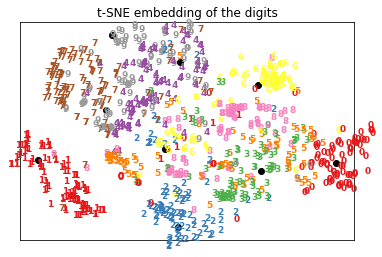

In [130]:
# for i in range(9):
#         print(sum((model.centers[i] - model.centers[i + 1]) ** 2) *100)

# temp = model.mid
centers = torch.from_numpy(kmeans.cluster_centers_)
temp = torch.cat((model.mid.type(torch.cuda.FloatTensor), centers.cuda().type(torch.cuda.FloatTensor)), 0)
tsne = TSNE(n_components=2, init='pca', random_state=0)
result = tsne.fit_transform(temp.cpu().detach())
fig, x_max, x_min = plot_embedding(result, Y[:1000].cpu().numpy(),
                     't-SNE embedding of the digits')
center = result[-10:]
center = (center - x_min) / (x_max - x_min)
plt.scatter(center[:, 0], center[:, 1], color='black')
plt.show(fig)





# X = model.encoder(Variable(X).cuda())
#
# kmeans(X, Y, batch_size = datasize, num_epochs = 300, ae = True)

In [ ]:
ax = range(num_epochs * (datasize // batch_size))
plt.title('acc')
plt.xlabel('epochs')
plt.plot(ax, acc, 'r', linewidth=2)
plt.show()
ax = range(num_epochs * (datasize // batch_size))
plt.title('loss')
plt.xlabel('epochs')
plt.plot(ax, loss, 'r', linewidth=2)
plt.show()
return model